In [12]:
# set tf 1.x for colab
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


# MNIST digits classification with Keras

We don't expect you to code anything here because you've already solved it with TensorFlow.

But you can appreciate how simpler it is with Keras.

We'll be happy if you play around with the architecture though, there're some tips at the end.

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)
import keras
print("We are using Keras", keras.__version__)

import sys
sys.path.append("../..")
import keras_utils
from keras_utils import reset_tf_session

C:\tools\Anaconda3\envs\hsefs\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\tools\Anaconda3\envs\hsefs\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\tools\Anaconda3\envs\hsefs\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\tools\Anaconda3\envs\hsefs\lib\site-packages\tensorflow\python\framework\dtypes.py:522: 

We're using TF 1.8.0


Using Theano backend.


We are using Keras 2.1.6


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15479050051811570065
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3167145166
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18180946587803041012
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [3]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


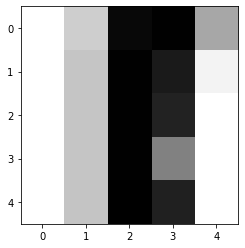

And the whole sample:


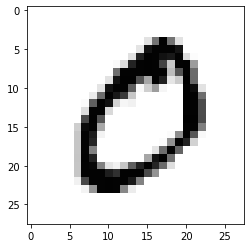

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [4]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

In [5]:
# flatten images
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [6]:
# one-hot encode the target
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [7]:
# building a model with keras
from keras.layers import Dense, Activation
from keras.models import Sequential

# we still need to clear a graph though
#s = reset_tf_session()

model = Sequential()  # it is a feed-forward network without loops like in RNN
model.add(Dense(256, input_shape=(784,)))  # the first layer must specify the input shape (replacing placeholders)
model.add(Activation('sigmoid'))
model.add(Dense(256))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [8]:
# you can look at all layers and parameter count
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [9]:
# now we "compile" the model specifying the loss and optimizer
model.compile(
    loss='categorical_crossentropy', # this is our cross-entropy
    optimizer='adam',
    metrics=['accuracy']  # report accuracy during training
)

In [10]:
# and now we can fit the model with model.fit()
# and we don't have to write loops and batching manually as in TensorFlow
model.fit(
    X_train_flat, 
    y_train_oh,
    batch_size=512, 
    epochs=40,
    validation_data=(X_val_flat, y_val_oh),
    callbacks=[keras_utils.TqdmProgressCallback()],
    verbose=0
)


Epoch 1/40


0it [00:00, ?it/s]


Epoch 2/40


0it [00:00, ?it/s]


Epoch 3/40


0it [00:00, ?it/s]


Epoch 4/40


0it [00:00, ?it/s]


Epoch 5/40


0it [00:00, ?it/s]


Epoch 6/40


0it [00:00, ?it/s]


Epoch 7/40


0it [00:00, ?it/s]


Epoch 8/40


0it [00:00, ?it/s]


Epoch 9/40


0it [00:00, ?it/s]


Epoch 10/40


0it [00:00, ?it/s]


Epoch 11/40


0it [00:00, ?it/s]


Epoch 12/40


0it [00:00, ?it/s]


Epoch 13/40


0it [00:00, ?it/s]


Epoch 14/40


0it [00:00, ?it/s]


Epoch 15/40


0it [00:00, ?it/s]


Epoch 16/40


0it [00:00, ?it/s]


Epoch 17/40


0it [00:00, ?it/s]


Epoch 18/40


0it [00:00, ?it/s]


Epoch 19/40


0it [00:00, ?it/s]


Epoch 20/40


0it [00:00, ?it/s]


Epoch 21/40


0it [00:00, ?it/s]


Epoch 22/40


0it [00:00, ?it/s]


Epoch 23/40


0it [00:00, ?it/s]


Epoch 24/40


0it [00:00, ?it/s]


Epoch 25/40


0it [00:00, ?it/s]


Epoch 26/40


0it [00:00, ?it/s]


Epoch 27/40


0it [00:00, ?it/s]


Epoch 28/40


0it [00:00, ?it/s]


Epoch 29/40


0it [00:00, ?it/s]


Epoch 30/40


0it [00:00, ?it/s]


Epoch 31/40


0it [00:00, ?it/s]


Epoch 32/40


0it [00:00, ?it/s]


Epoch 33/40


0it [00:00, ?it/s]


Epoch 34/40


0it [00:00, ?it/s]


Epoch 35/40


0it [00:00, ?it/s]


Epoch 36/40


0it [00:00, ?it/s]


Epoch 37/40


0it [00:00, ?it/s]


Epoch 38/40


0it [00:00, ?it/s]


Epoch 39/40


0it [00:00, ?it/s]


Epoch 40/40


0it [00:00, ?it/s]

# Here're the notes for those who want to play around here

Here are some tips on what you could do:

 * __Network size__
   * More neurons, 
   * More layers, ([docs](https://keras.io/))

   * Other nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - https://keras.io/regularizers/
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * https://keras.io/preprocessing/image/
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.